In [1]:
import numpy as np
import pandas as pd
import warnings
import numpy as np
from itertools import product
from turtle import shape
import pygad
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = ['sans-serif']   
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_excel('酶复配数据集.xlsx') 
data = data.drop_duplicates()


In [2]:
label_encoder = LabelEncoder()
data['酶'] = label_encoder.fit_transform(data['酶'])
data['助剂'] = label_encoder.fit_transform(data['助剂'])

In [3]:
data

,酶,助剂,pH,浓度,孵育温度,孵育时间,酶活
0,0,0,7.5,0.002,70,40,0.065300
1,0,0,6.0,0.010,70,40,0.365800
2,0,0,7.5,0.010,70,60,0.408300
3,0,0,7.5,0.100,70,40,0.606200
4,0,0,7.5,0.002,30,40,0.805400
...,...,...,...,...,...,...,...
205,1,0,9.0,0.010,70,40,0.029822
206,1,3,9.0,0.010,70,40,0.026936
207,1,8,6.0,0.010,70,40,0.036556
208,1,8,9.0,0.010,70,40,0.039923


[0, 0]
[1, 1]
[2, 2]
[3, 3]
[4, 4]
[5, 5]
[6, 6]


<Axes: >

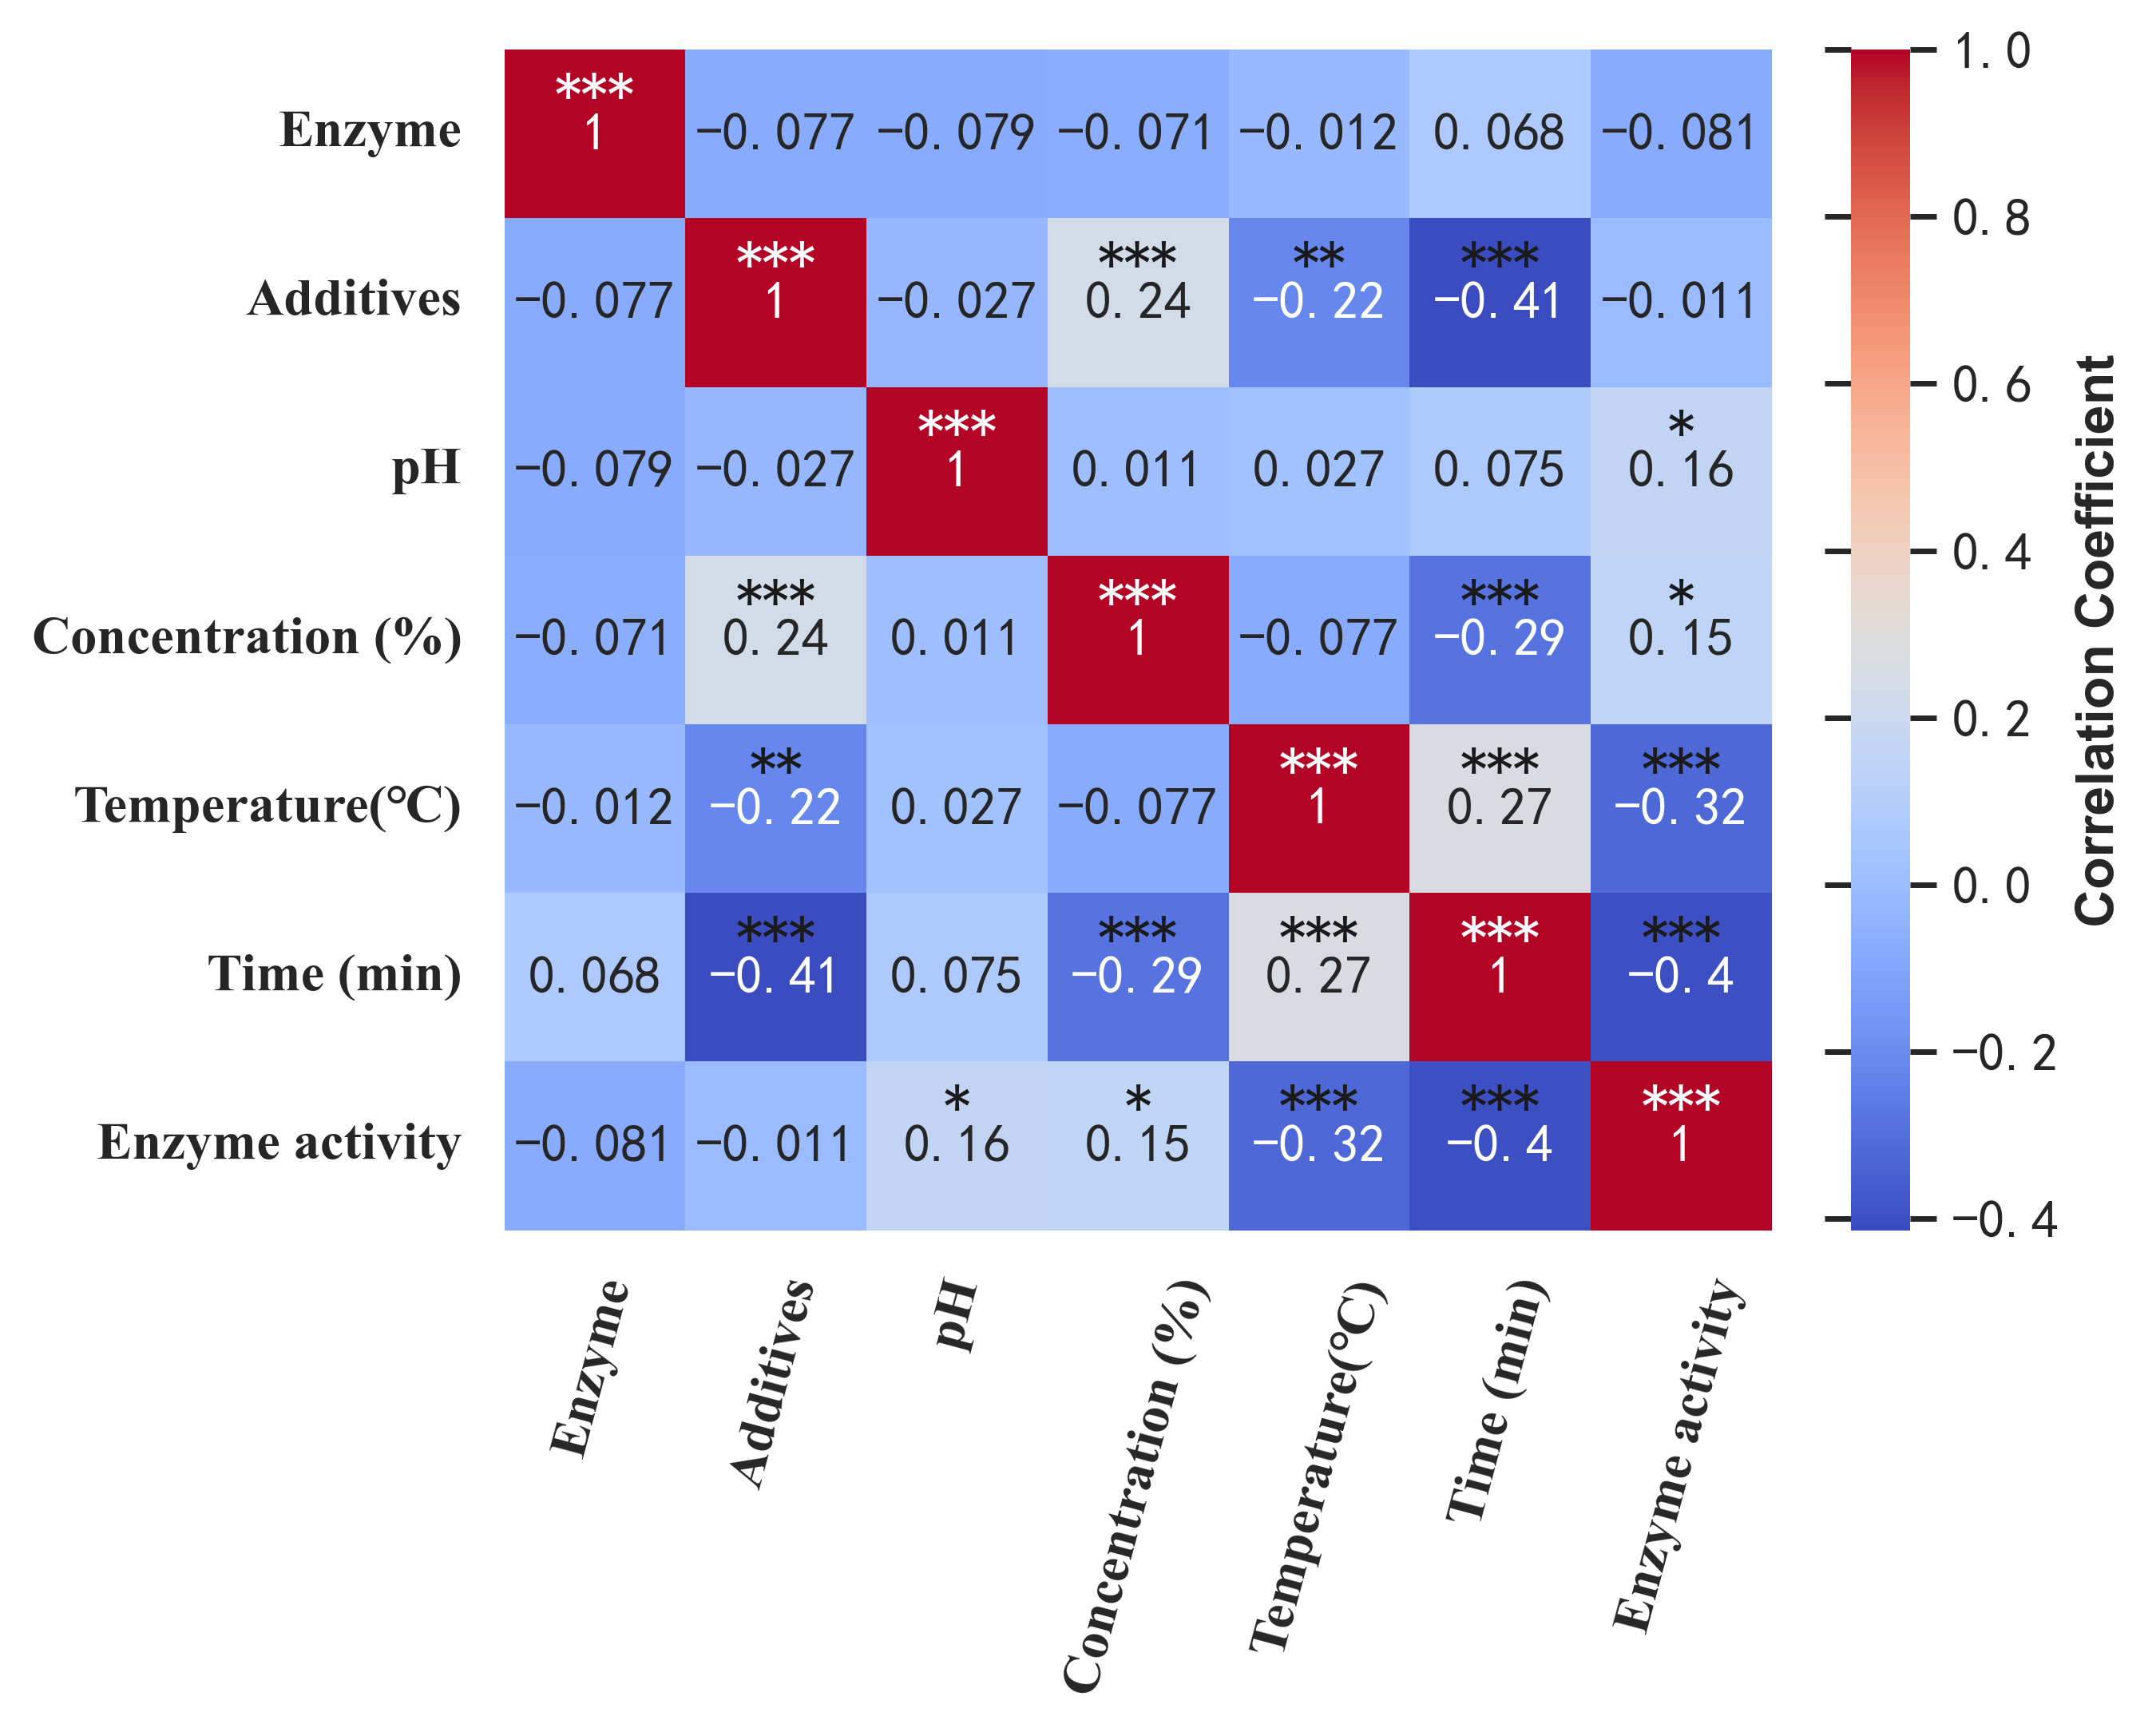

In [4]:
import scipy.stats as stats
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
sns.set(font='SimHei') 
data_2 = pd.read_excel('酶复配数据集.xlsx')
data_2['酶'] = label_encoder.fit_transform(data_2['酶'])
data_2['助剂'] = label_encoder.fit_transform(data_2['助剂'])
data_2 = data_2.rename(columns={'酶': 'Enzyme'})
data_2 = data_2.rename(columns={'助剂':'Additives'})
data_2 = data_2.rename(columns={'浓度':'Concentration (%)'})
data_2 = data_2.rename(columns={'孵育温度':'Temperature(℃)'})
data_2 = data_2.rename(columns={'孵育时间':'Time (min)'})
data_2 = data_2.rename(columns={'酶活':'Enzyme activity'})
features_all2 = data_2.corr()    
plt.figure(dpi=400)

mask = np.zeros_like(features_all2)
mask[np.triu_indices_from(mask)] = False
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)



ax = sns.heatmap(features_all2,cmap = 'coolwarm',annot =True)

rlist = []
plist = []
for i in data_2.columns.values:
    for j in data_2.columns.values:
        r,p = stats.pearsonr(data_2[i],data_2[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(data_2.columns.values),len(data_2.columns.values))
parr = np.asarray(plist).reshape(len(data_2.columns.values),len(data_2.columns.values))
xlist = ax.get_xticks()
ylist = ax.get_yticks()

widthx = 0
widthy = -0.15

for m in ax.get_xticks():
    for n in ax.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
                    
cbar = ax.collections[0].colorbar  
cbar.set_label('Correlation Coefficient', fontname='Arial',fontweight='bold')  
cbar.ax.tick_params(labelsize=12)    
cbar.ax.yaxis.set_ticks_position('both') 
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='Times New Roman', fontsize=12, fontweight='bold',rotation=75)  
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='Times New Roman', fontsize=12, fontweight='bold', )  
plt.savefig('RR单酶预测热力图.jpg', dpi=600, bbox_inches='tight')
ax

In [7]:
x_ = data.drop(columns=['酶活'], axis=1)
y_ = data['酶活']
scaler = MinMaxScaler()
scaler.fit(x_) 
x_transfer = scaler.transform(x_) 
x_train_,x_test_,y_train_,y_test_ = train_test_split(x_transfer,y_,test_size = 0.2,random_state = 44) 

In [8]:
ridge_ = Ridge()
alpha_ = np.linspace(0,100,1000)
ridge_model_ = GridSearchCV(ridge_, param_grid={'alpha': alpha_}, cv=10)
ridge_model_.fit(x_train_, y_train_)
print('RR模型的最佳验证参数：\n', ridge_model_.best_params_)

RR模型的最佳验证参数：
 {'alpha': 1.1011011011011012}


In [9]:
pre1 = ridge_model_.predict(x_train_)
pre2 = ridge_model_.predict(x_test_)
R2_1 = r2_score(y_train_,pre1)
R2_2 = r2_score(y_test_,pre2)
print("train_model's R2: {:.4f}".format(R2_1))
print("test_model's R2: {:.4f}".format(R2_2))
mse_train_ = np.mean(np.power(y_train_ - pre1, 2))
mse_test_ = np.mean(np.power(y_test_ - pre2, 2))
print("train_model's MSE: {:.4f}".format(mse_train_))
print("test_model's MSE: {:.4f}".format(mse_test_))
print("train_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_train_,pre1)))
print("test_model's RMSE:",np.sqrt(metrics.mean_squared_error(y_test_,pre2)))

train_model's R2: 0.2790
test_model's R2: 0.3550
train_model's MSE: 0.0946
test_model's MSE: 0.0726
train_model's RMSE: 0.30750026116993107
test_model's RMSE: 0.2695068508158869


In [10]:
data = pd.read_excel('多酶复配数据集.xlsx')
data = data.drop_duplicates()

In [11]:
enzyme1, assistant1 = 'Ba', 'AKD'
enzyme2, assistant2 = 'XYN', 'AKD'


data_index1 = (data['酶'] == enzyme1) & (data['助剂'] == assistant1)
data_index2 = (data['酶'] == enzyme2) & (data['助剂'] == assistant2)

In [12]:
label_encoder = LabelEncoder()
data['酶'] = label_encoder.fit_transform(data['酶'])
data['助剂'] = label_encoder.fit_transform(data['助剂'])

In [13]:
data1 = data[data_index1]
data2 = data[data_index2]
X1 = data1[['pH', '浓度', '孵育温度', '孵育时间']]
X2 = data2[['pH', '浓度', '孵育温度', '孵育时间']]
y1 = data1['酶活']
y2 = data2['酶活']


In [14]:
def used_model(X_train, y_train): 
    ridge = Ridge() 
    alpha_can = np.linspace(0,100,100)
    ridge_model = GridSearchCV(ridge, param_grid={'alpha': alpha_can}, cv=10)
    ridge_model.fit(X_train, y_train)
    print('模型的最佳验证参数：\n', ridge_model.best_params_)
    return ridge_model
    # 返回模型

In [15]:
def remove_duplicates(arr):
    _, idx = np.unique(arr, axis=0, return_index=True)
    return arr[np.sort(idx)]

def gaga(gp, gp2):
    last_fitness = 0

    def fitness_func(index, solution, solution_idx):
        pred = gp.predict([solution])
        pred2 = gp2.predict([solution])
        Z = pred[0]+pred2[0]
        return Z

    def on_generation(ga_instance):
        global last_fitness
        last_fitness = ga_instance.best_solution(
            pop_fitness=ga_instance.last_generation_fitness)[1]

    last_fitness = 0
    # 调用pygad
    ga_instance = pygad.GA(num_generations=100,  # 可调参数
                           num_parents_mating=8,  # 可调参数
                           sol_per_pop=10,  # 可调参数
                           num_genes=4,
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes='default',
                           # 此处可挑输出指标数值范围 range(7, 9, 1) 为pH的取值范围 7最小 9最大 1为步长 若要步长为小数应把range换np.arange
                           gene_space=[range(7, 9, 1), np.arange(0.001, 0.1, 0.002), range(30, 80, 10), range(20, 80, 10)],
                           mutation_by_replacement=True,
                           fitness_func=fitness_func,
                           on_generation=on_generation,
                           save_solutions=True,
                           random_seed=36)

    ga_instance.run()
    ga_instance.plot_result()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    ga_s = np.array(ga_instance.solutions)
    ga_sf = np.array(ga_instance.solutions_fitness)
    ga_res = np.c_[ga_s,ga_sf]
    sort_idx = np.argsort(ga_res[:, 4])[::-1]
    # 使用sort_idx对原数组进行重排
    sorted_arr = ga_res[sort_idx]
    sorted_arr = remove_duplicates(sorted_arr)
    nums_pf = 15  # 前几个配方  可改参数
    score = sorted_arr[:nums_pf, 4]
    score = (score / score[0]) * 100
    print('The input enzymes and additives were:')
    print(enzyme1, assistant1)
    print(enzyme2, assistant2)
    print("The optimal reaction conditions are pH:{}, Concentration:{:.4f}, Temperature:{}, Time:{}".format(solution[0], solution[1],solution[2],solution[3]))
    print('----------------------------------')
    print('Recommended reaction conditions:')
    print('pH\t Concentration(%)\t Temperature(℃)\t Time(min)\t score')
    for i in range(nums_pf):
        print(sorted_arr[i][0], '\t', '{:.4f}'.format(sorted_arr[i][1]), '\t\t',
              sorted_arr[i][2], '\t\t\t', sorted_arr[i][3], '\t''\t',
              '{:.2f}'.format(score[i]))


模型的最佳验证参数：
 {'alpha': 0.0}
模型的最佳验证参数：
 {'alpha': 14.141414141414142}


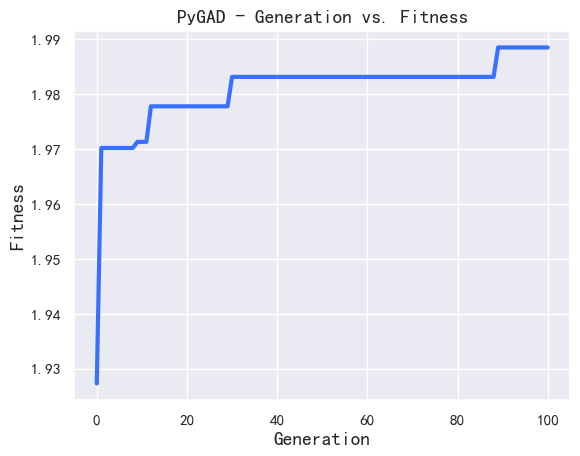

The input enzymes and additives were:
Ba AKD
XYN AKD
The optimal reaction conditions are pH:8.0, Concentration:0.0970, Temperature:30.0, Time:20.0
----------------------------------
Recommended reaction conditions:
pH	 Concentration(%)	 Temperature(℃)	 Time(min)	 score
8.0 	 0.0970 		 30.0 			 20.0 		 100.00
8.0 	 0.0930 		 30.0 			 20.0 		 99.73
8.0 	 0.0970 		 30.0 			 30.0 		 99.67
8.0 	 0.0910 		 30.0 			 20.0 		 99.60
8.0 	 0.0990 		 30.0 			 40.0 		 99.48
8.0 	 0.0890 		 30.0 			 20.0 		 99.46
8.0 	 0.0930 		 30.0 			 30.0 		 99.40
8.0 	 0.0970 		 30.0 			 40.0 		 99.35
8.0 	 0.0870 		 30.0 			 20.0 		 99.33
8.0 	 0.0910 		 30.0 			 30.0 		 99.27
8.0 	 0.0850 		 30.0 			 20.0 		 99.19
8.0 	 0.0890 		 30.0 			 30.0 		 99.14
8.0 	 0.0930 		 30.0 			 40.0 		 99.08
8.0 	 0.0830 		 30.0 			 20.0 		 99.06
8.0 	 0.0970 		 30.0 			 50.0 		 99.02


In [16]:
gp1 = used_model(X1, y1)
gp2 = used_model(X2, y2)
gaga(gp1, gp2)

model's R2: 0.5569
model's MSE: 0.0292
model's RMSE: 0.17076770512819717


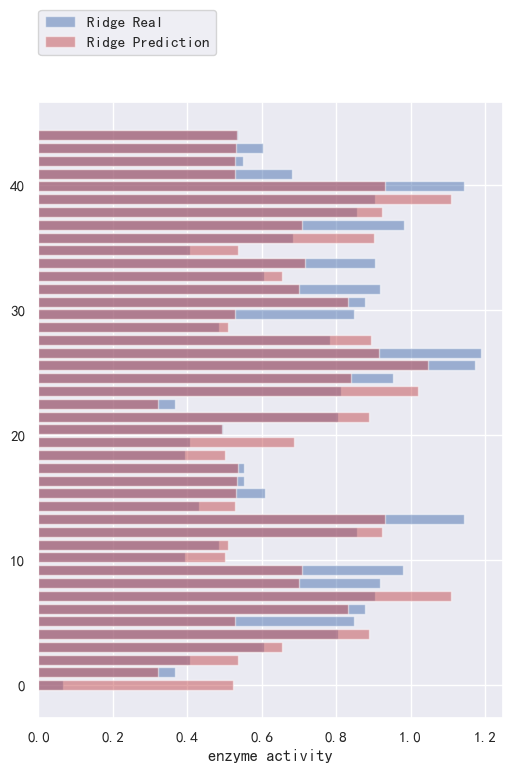

In [18]:
from sklearn.metrics import r2_score
pre1 = gp1.predict(X1)
pre2 = gp1.predict(X2)
pre = np.concatenate((pre1, pre2))
y = np.concatenate((y1, y2))

R2 = r2_score(y,pre)
SSR = np.sum((y-pre)**2)
SST = np.sum((y-np.mean(y))**2)
r2 = 1 - SSR/(SST+1e-9)
print("model's R2: {:.4f}".format(r2))
mse_test = np.mean(np.power(y - pre, 2))
print("model's MSE: {:.4f}".format(mse_test))
print("model's RMSE:",np.sqrt(metrics.mean_squared_error(y,pre)))


fig = plt.figure(figsize=(6,8))
x = np.linspace(0,y.shape[0],y.shape[0])
plt.barh(x,y,color='b',alpha=0.5,label='Ridge Real')
plt.barh(x,pre, color = 'r',alpha=0.5,label='Ridge Prediction')
plt.xlabel("enzyme activity")
plt.legend(bbox_to_anchor=(0, 1.15), loc=2, borderaxespad=0)
plt.savefig('RR模型多酶预测柱状图图.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
data_seaborn = pd.DataFrame()
data_seaborn['enzyme activity_true'] = y
data_seaborn['enzyme activity_pred'] = pre

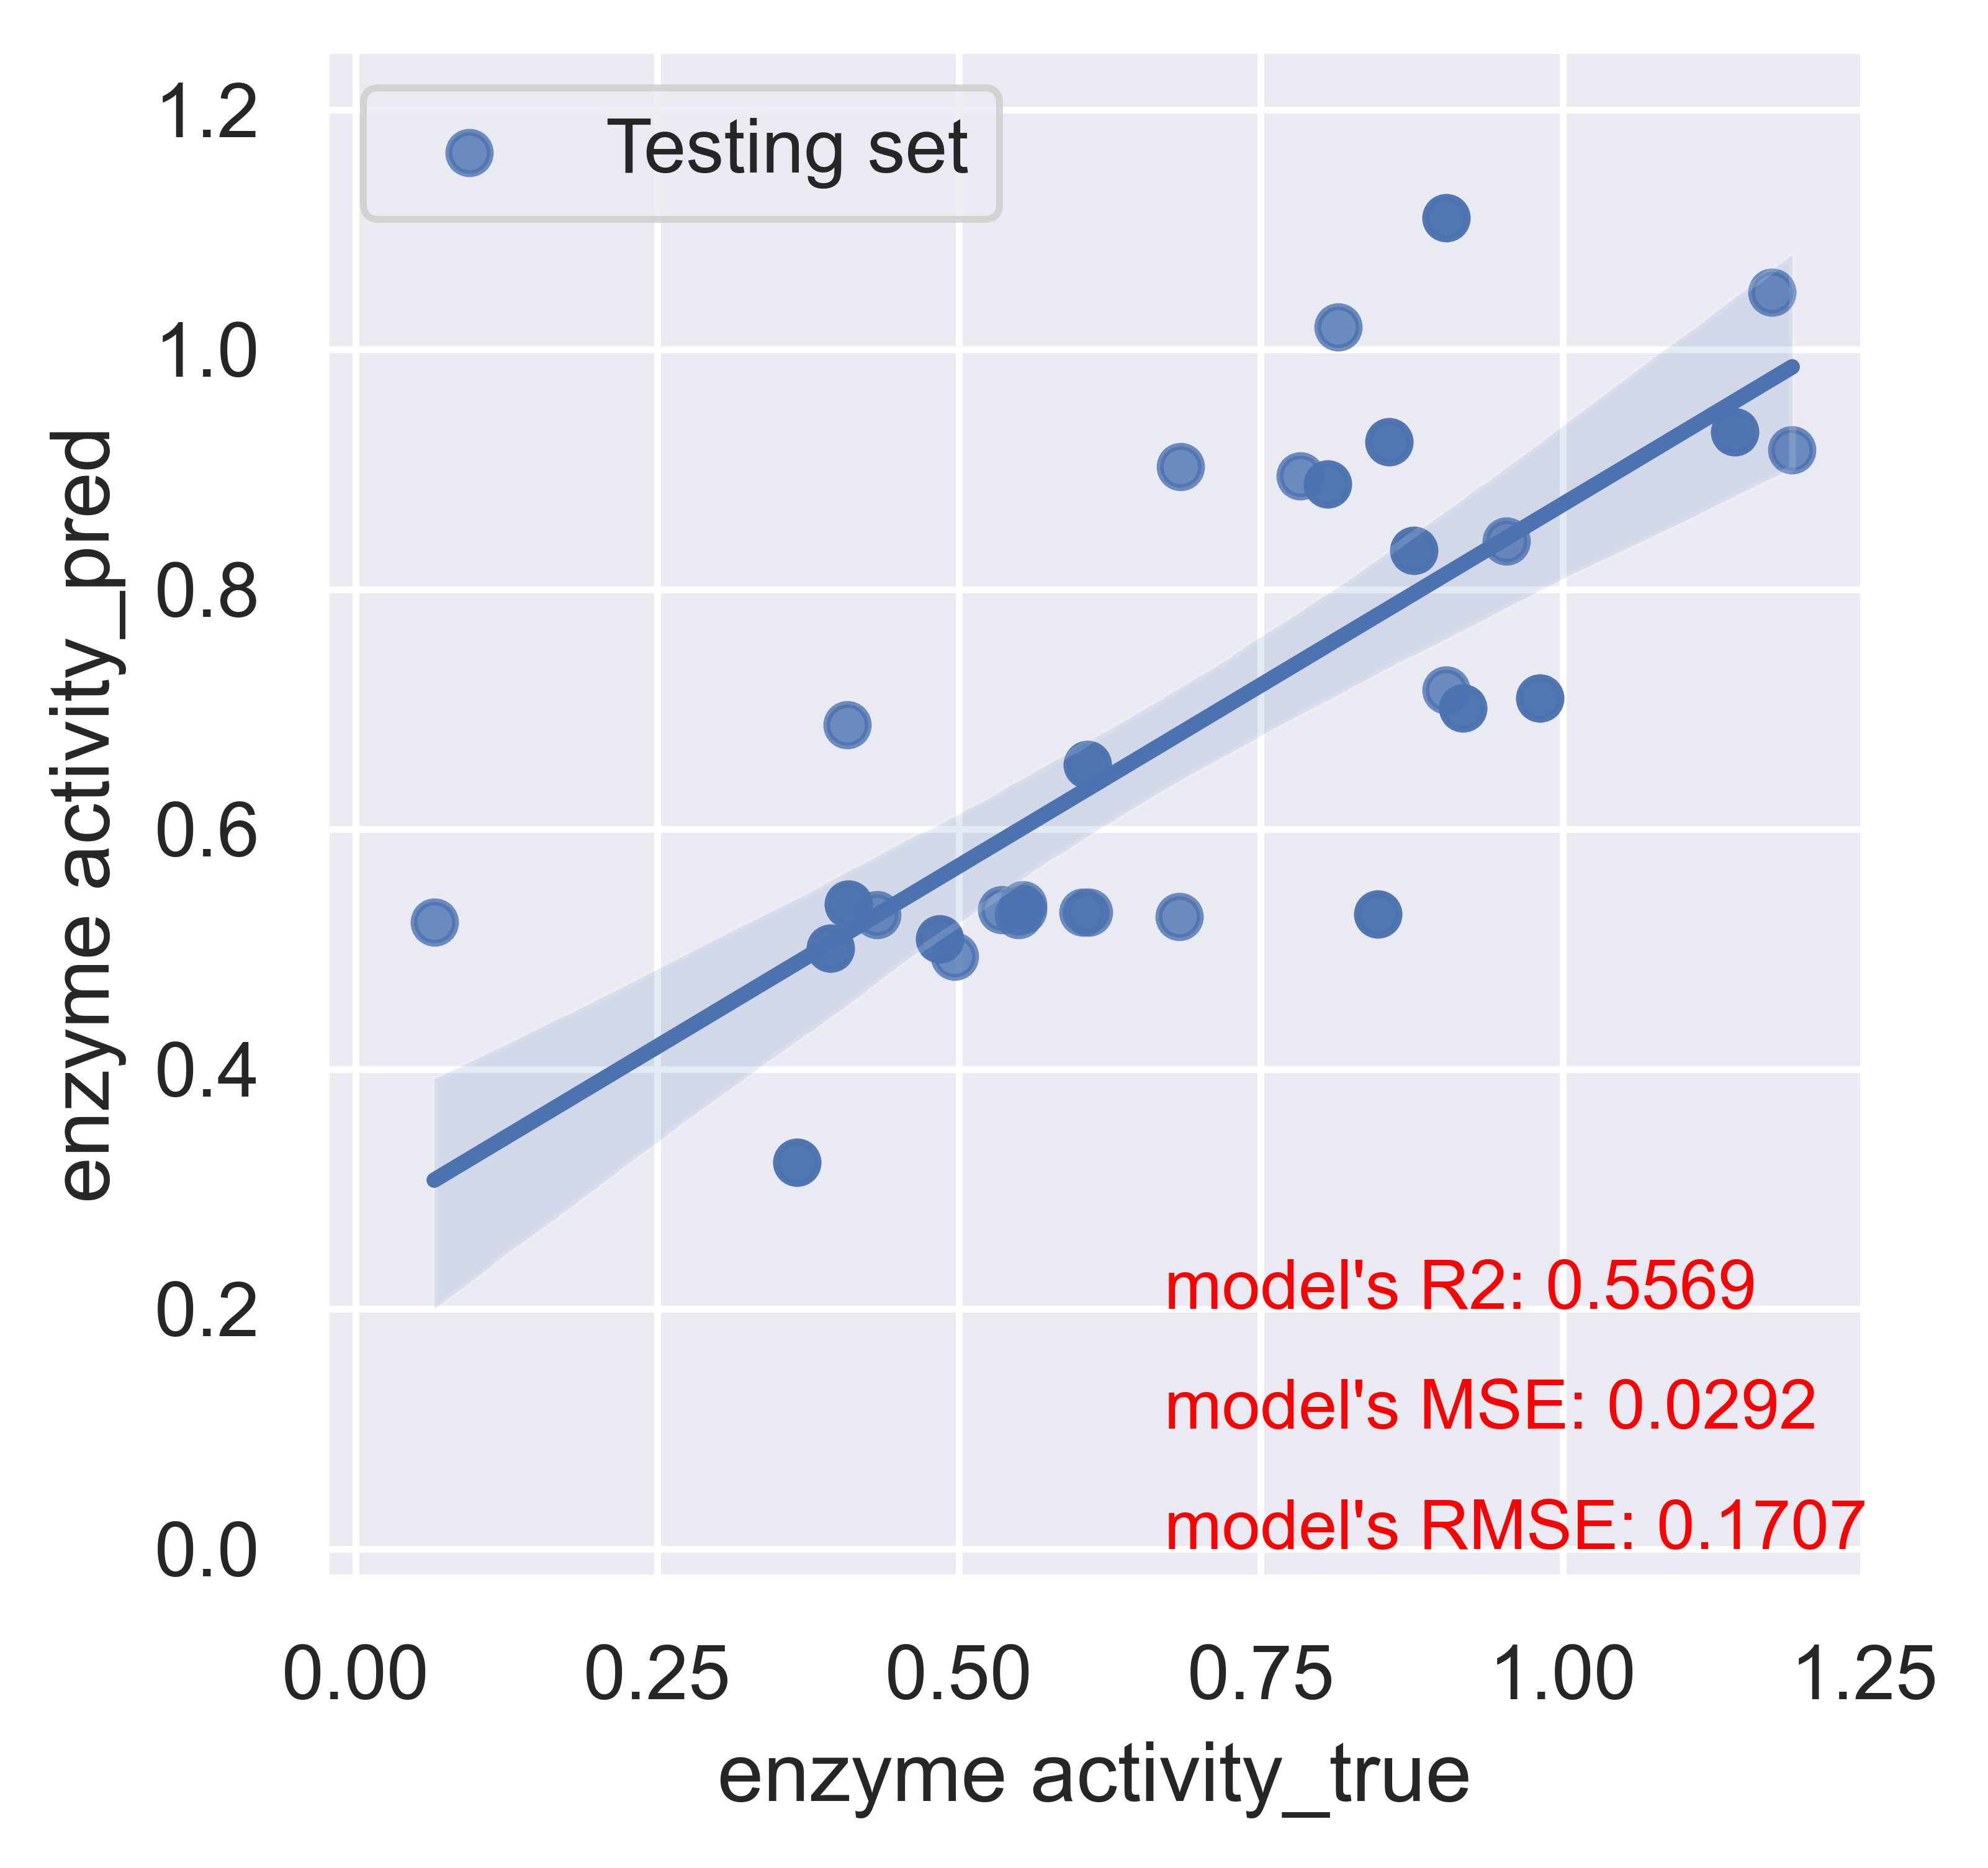

In [24]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 
plt.figure(dpi=800, figsize=(4,4))
plt.xlim([-0.025, 1.25])   
plt.ylim([-0.025, 1.25]) 
sns.set(font='SimHei')
sns.set(color_codes=True)
sns.regplot(x=data_seaborn['enzyme activity_true'],y=data_seaborn['enzyme activity_pred'],label="Testing set")
plt.legend(loc='upper left')
plt.text(0.67, 0.2, "model's R2: 0.5569", fontsize=10, color='red')   
plt.text(0.67, 0.1, "model's MSE: 0.0292", fontsize=10, color='red')  
plt.text(0.67, 0, "model's RMSE: 0.1707", fontsize=10, color='red')  
plt.savefig('RR多酶预测线性回归图.jpg', dpi=600, bbox_inches='tight')